In [1]:
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
library(argparse)
library(tidyverse)
library(ggplot2)
library(rstatix)
library(ggrepel)
library(preprocessCore)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:
mergeActivitiesContacts <- function(fnames,
                                    activity_col='activity_base',
                                    contact_col='hic_contact',
                                    bin_totals=FALSE,
                                    min_hic=0,
                                    merge_nonexpr=FALSE,
                                    debug=FALSE) {

    samp_col <- 'CellType'
    acols <- c('chr','start','end','name',activity_col)
    ccols <- c('chr','start','end','name','TargetGene',contact_col)

    if (bin_totals) {
        acols <- c(acols, 'hic_enh_total')
    }

    i <- 0
    prev_sn <- 'no sample'
    for (fn in fnames) {

        if (debug & i>1) break

        f <- read_tsv(fn)
        fa <- f %>% dplyr::select(all_of(acols)) %>% distinct()
        fc <- f %>% dplyr::select(all_of(ccols))

        if (bin_totals) {
            fa <- fa %>%
                # replace 'fake NAs' (generated by sparse matrix represenation of
                # zero hic_contact for 2 specific bins) with real bin total
                # from where bin was part of non-zero hic_contact (if applicable)
                group_by(across(all_of(acols[-length(acols)]))) %>%
                arrange(hic_enh_total, .by_group=TRUE) %>%
                dplyr::slice(1) %>%
                ungroup() %>%
                # real NAs have not been replaced yet for hic bin totals
                mutate(across(hic_enh_total, ~replace_na(.x, 0)))
        }

        sn <- str_split(f[[samp_col]][1],pattern='\\.',simplify=TRUE)[1]
        print(paste(sn, 'processing...'))
        rm(f)

        preN <- nrow(fa)
        fa <- fa %>%
            dplyr::filter(.data[[activity_col]]>=min_hic)
        if (bin_totals) {
            fa <- fa %>%
                dplyr::filter(hic_enh_total>=min_hic)
        }
        postN <- nrow(fa)
        print(paste(preN - postN,'elements dropped with',activity_col,'<',min_hic))

        preN <- nrow(fc)
        fc <- fc %>%
            dplyr::filter(.data[[contact_col]]>=min_hic)
        postN <- nrow(fc)
        print(paste(preN - postN,'elements dropped with',contact_col,'<',min_hic))

        fa <- fa %>%
            dplyr::rename("{activity_col}.{sn}" := {{activity_col}})
        if (bin_totals) {
            fa <- fa %>%
                dplyr::rename("hic_enh_total.{sn}" := hic_enh_total)
        }
        fc <- fc %>%
            dplyr::rename("{contact_col}.{sn}" := {{contact_col}})

        if (merge_nonexpr) {

            if (sn==prev_sn) {
                print('Concatenating activities/contacts for non-expressed genes')
                cfa <- rbind(cfa, fa) %>% distinct()
                cfc <- rbind(cfc, fc) %>% distinct()
                if (i==0) {
                    sa <- cfa
                    sc <- cfc
                } else {
                    print('    Merging activities...')
                    sa <- merge(sa, cfa)
                    print('    Merging contacts...')
                    sc <- merge(sc, cfc)
                }
                i <- i + 1
            } else {
                cfa <- fa
                cfc <- fc
                prev_sn <- sn
            }

        } else {

            if (i==0) {
                sa <- fa
                sc <- fc
            } else {
                print('    Merging activities...')
                sa <- merge(sa, fa)
                print('    Merging contacts...')
                sc <- merge(sc, fc)
            }
            i <- i + 1

        }


    }

    return(list(sa, sc))

}

qnorm_df <- function(df, colprefix='activity_base') {

    mat <- df %>%
        dplyr::select(dplyr::starts_with(colprefix)) %>%
        as.matrix()

    # no keep.names arg in older versions of preprocessCore
    matnames <- colnames(mat)
    matqn <- normalize.quantiles(mat)
    colnames(matqn) <- matnames

    dfqn <- cbind(
        df %>% dplyr::select(-starts_with(colprefix)),
        matqn
    )

    return(dfqn)
}

qnorm_separate_promoters <- function(df, colprefix='activity_base', filt_zeros=NULL) {

    # filt_zeros: all = filter out elements that are zero in all samples post-QN
    #             any = filter out elements that are zero in any sample post-QN

    if (!('class' %in% colnames(df))) {

        if (!('name' %in% colnames(df))) {
            stop('No promoter column info found...')
        }

        df <- df %>% separate(name,c('class',NA),sep='\\|',remove=FALSE)

    }

    pdf <- df %>% dplyr::filter(class=='promoter')
    npdf <- df %>% dplyr::filter(class!='promoter')

    pdfqn <- qnorm_df(pdf, colprefix=colprefix)
    npdfqn <- qnorm_df(npdf, colprefix=colprefix)

    dfqn <- rbind(pdfqn, npdfqn)

    if (filt_zeros=='all') { # filter out elements that are zero in all samples
      dfqn <- dfqn %>%
          dplyr::filter(if_any(starts_with(colprefix), ~ . > 0))
    } else if (filt_zeros=='any') { # filter out elements that are zero in any sample
      dfqn <- dfqn %>%
          dplyr::filter(if_all(starts_with(colprefix), ~ . > 0))
    } else {
      print("Keeping all post-QN zeros!")
    }

    return(dfqn)

}

compute_score <- function(df,
                          activity_col='activity_base',
                          contact_col='hic_contact_pl_scaled_adj',
                          prefix='ABC') {

    if (prefix %in% c('ABC','powerlaw')) {

        df <- df %>%
            mutate("{prefix}.Score.Numerator" := .data[[activity_col]] * .data[[contact_col]]) %>%
            group_by(TargetGene) %>%
            mutate(nEnh.ABC = sum(!is.na(.data[[paste0(prefix,'.Score.Numerator')]])), # to check that this is equal across samples
                   "{prefix}.Score" := .data[[paste0(prefix,'.Score.Numerator')]] / sum(.data[[paste0(prefix,'.Score.Numerator')]], na.rm=TRUE)) %>%
            ungroup()

    } else if (prefix=='chip') {

        df <- df %>%
            mutate(chip_estimate = sqrt(hic_enh_total * hic_tss_total)) %>%
            group_by(TargetGene) %>%
            mutate(nEnh.chip = sum(!is.na(chip_estimate)), # to check that this is equal across samples
                   chip_estimate_sum = sum(chip_estimate, na.rm=TRUE),
                   chip_estimate_sum1 = chip_estimate / sum(chip_estimate, na.rm=TRUE),
                   chip_estimate_adj = chip_estimate_sum1 / max(chip_estimate_sum1, na.rm=TRUE),
                   "{prefix}.Score" := chip_estimate_adj / sum(chip_estimate_adj, na.rm=TRUE)) %>%
            ungroup()

    } else if (prefix=='hic') {

        df <- df %>%
            mutate("{prefix}.Score.Numerator" := hic_estimate_adj) %>%
            group_by(TargetGene) %>%
            mutate(nEnh.hic = sum(!is.na(hic_estimate_adj)), # to check that this is equal across samples
                   "{prefix}.Score" := .data[[paste0(prefix,'.Score.Numerator')]] / sum(.data[[paste0(prefix,'.Score.Numerator')]], na.rm=TRUE)) %>%
            ungroup()

    } else if (prefix=='atac') {

        df <- df %>%
            mutate("{prefix}.Score.Numerator" := activity_base) %>%
            group_by(TargetGene) %>%
            mutate(nEnh.atac = sum(!is.na(activity_base)), # to check that this is equal across samples
                   activity_base_sum = sum(activity_base, na.rm=TRUE),
                    "{prefix}.Score" := .data[[paste0(prefix,'.Score.Numerator')]] / sum(.data[[paste0(prefix,'.Score.Numerator')]], na.rm=TRUE)) %>%
            ungroup()

    } else if (prefix=='activity') {

        df <- df %>%
            # estimate activity as geometric mean of chip extimate and atac
            mutate(activity_estimate = sqrt(activity_base * chip_estimate)) %>%
            group_by(TargetGene) %>%
            mutate(nEnh.activity = sum(!is.na(activity_estimate)), # to check that this is equal across samples
                   activity_estimate_sum = sum(activity_estimate, na.rm=TRUE),
                   activity_estimate_sum1 = activity_estimate / sum(activity_estimate, na.rm=TRUE),
                   activity_estimate_adj = activity_estimate_sum1 / max(activity_estimate_sum1, na.rm=TRUE),
                    "{prefix}.Score" := activity_estimate_adj / sum(activity_estimate_adj, na.rm=TRUE)) %>%
            ungroup()

    } else {
      stop(paste0("Score prefix '",prefix,"' not supported."))
    }



    return(df)

}

normalize_hichip <- function(df, decomp_scores=FALSE) {

    df <- df %>%
        # keep duplicate hichip columns for colname compatibility
        mutate(hic_contact_pl_scaled = normalized_hic_contact) %>%
        group_by(TargetGene) %>%
        mutate(hic_contact_sum = sum(hic_contact_pl_scaled, na.rm=TRUE), # for bias check
               hic_contact_sum1 = hic_contact_pl_scaled / sum(hic_contact_pl_scaled, na.rm=TRUE),
               hic_contact_pl_scaled_adj = hic_contact_sum1 / max(hic_contact_sum1, na.rm=TRUE)) %>%
        ungroup()

    if (decomp_scores) {

      df <- df %>%
          mutate(hic_estimate = hic_contact_pl_scaled / chip_estimate) %>%
          group_by(TargetGene) %>%
          mutate(hic_enh_total_sum = sum(hic_enh_total, na.rm=TRUE),
                 hic_tss_total_sum = sum(hic_tss_total, na.rm=TRUE),
                 hic_estimate_sum = sum(hic_estimate, na.rm=TRUE),
                 hic_estimate_sum1 = hic_estimate / sum(hic_estimate, na.rm=TRUE),
                 hic_estimate_adj = hic_estimate_sum1 / max(hic_estimate_sum1, na.rm=TRUE)) %>%
          ungroup() %>%
          mutate(hic_estimate_adj_old = hic_contact_pl_scaled_adj / chip_estimate_adj)

    }

    return(df)

}

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

makeQNpredictions <- function(fnames, adf, edf, cdf, outdir='.', decomp_scores=FALSE, filt_zeros=NULL) {

    # takes list of prediction files (`fnames`) made without Q-norm and
    # replaces unnormalized activities and contacts with Q-normed values
    # corresponding to each samples's file from `adf` (Q-normed activities)
    # and `cdf` (Q-normed contacts), then computes ABC scores using the
    # new Q-normed values and overwriting the old scores

    if (decomp_scores) library(plyranges)

    samp_col <- 'CellType'
    replace_cols <- c('activity_base',
                      'TargetGenePromoterActivityQuantile',
                      'hic_enh_total',
                      'hic_tss_total',
                      'normalized_hic_contact',
                      'hic_contact_pl_scaled',
                      'hic_contact_sum1',
                      'hic_contact_pl_scaled_adj',
                      'ABC.Score.Numerator',
                      'ABC.Score',
                      'powerlaw.Score.Numerator',
                      'powerlaw.Score')

    remove_cols <- c('pop','replicate')
    adf <- adf %>% dplyr::select(-any_of(remove_cols))
    cdf <- cdf %>% dplyr::select(-any_of(remove_cols))
    edf <- edf %>% dplyr::select(-any_of(remove_cols))

    i <- 0
    for (fn in fnames) {

        f <- read_tsv(fn) %>%
            dplyr::select(-all_of(replace_cols))
        sn <- str_split(f[[samp_col]][1],pattern='\\.',simplify=TRUE)[1]
        print(paste(sn, 'processing...'))

        # # activities
        # currcol <- c(paste0('activity_base.',sn))
        # currcola <- currcol[1]
        # if (decomp_scores) {
        #     currcol <- c(currcol, paste0('hic_enh_total.',sn))
        #     currcolb <- currcol[2]
        # }
        # curr_adf <- adf %>%
        #     dplyr::select(-starts_with(c('activity_base','hic_enh_total')),all_of(currcol)) %>%
        #     dplyr::rename(activity_base := {{currcola}})
        # if (decomp_scores) curr_adf <- curr_adf %>% dplyr::rename(hic_enh_total := {{currcolb}})
        # print('    Merging activities...')
        # f <- merge(f, curr_adf)

        # activities
        currcol <- paste0('activity_base.',sn)
        curr_adf <- adf %>%
            dplyr::select(-starts_with('activity_base'),all_of(c(currcol))) %>%
            dplyr::rename(activity_base := {{currcol}})
        print('    Merging activities...')
        af <- merge(f, curr_adf)
        print("    Computing atac.Score ...")
        af <- compute_score(af, prefix='atac')
        print("    Computing powerlaw.Score ...")
        af <- compute_score(af, contact_col='powerlaw_contact_reference', prefix='powerlaw')

        if (decomp_scores) {

            # chip estimate
            currcol <- paste0('hic_enh_total.',sn)
            curr_edf <- edf %>%
                dplyr::select(-starts_with('hic_enh_total'),all_of(c(currcol))) %>%
                dplyr::rename(hic_enh_total := {{currcol}})
            ef <- merge(f, curr_edf)

            column_order <- c(colnames(ef), 'hic_tss_total')

            # overlap hic_enh_totals with TargetGeneTSSs to get Qnormed
            # hic_tss_totals
            ef <- ef %>%
                dplyr::rename(enh_start = start,
                              enh_end = end,
                              seqnames = chr,
                              start = TargetGeneTSS) %>%
                mutate(end = start + 1) %>%
                as_granges()

            curr_edf <- curr_edf %>%
                dplyr::filter(class=='promoter') %>%
                dplyr::select(chr, start, end, hic_enh_total) %>%
                dplyr::rename(seqnames = chr,
                              hic_tss_total = hic_enh_total) %>%
                as_granges()

            ef <- join_overlap_left(ef, curr_edf) %>%
                as_tibble() %>%
                dplyr::select(-end) %>%
                dplyr::rename(TargetGeneTSS = start,
                              chr = seqnames,
                              start = enh_start,
                              end = enh_end) %>%
                dplyr::select(all_of(column_order))

            print("    Computing chip.Score ...")
            ef <- compute_score(ef, prefix='chip')

        }

        # contacts
        currcol <- paste0('hic_contact.',sn)
        curr_cdf <- cdf %>%
            dplyr::select(-starts_with('hic_contact'),all_of(c(currcol))) %>%
            dplyr::rename(normalized_hic_contact := {{currcol}})
        print('    Merging contacts...')
        # merge with pre-computed ChIP scores since non-zero contacts should be
        # a subset of these, but check this
        Npre <- nrow(ef)
        ef <- merge(ef, curr_cdf)
        Npost <- nrow(ef)
        zeros_print <- filt_zeros
        if (is.null(zeros_print)) zeros_print <- "no zeros filtered"
        print(paste0(Npre-Npost, " non-zero hic_enh_total elements dropped with zero (", zeros_print, ") hic_contact"))

        # compute scores
        print('    Normalizing HiChIP components...')
        ef <- normalize_hichip(ef, decomp_scores=decomp_scores)
        if (decomp_scores) {
            print('    Computing hic.Score ...')
            ef <- compute_score(ef, prefix='hic')
        }

        # merge activities and contacts for ABC.Score calculation
        f <- merge(af, ef)

        print("    Computing activity.Score ...")
        f <- compute_score(f, prefix='activity')

        outprefix <- paste0(sn, '.meanQN')
        f <- compute_score(f,
                           activity_col='activity_base',
                           contact_col='hic_contact_pl_scaled_adj',
                           prefix='ABC') %>%
            dplyr::select(-CellType) %>%
            mutate(CellType = outprefix)


        # output
        if (is.null(filt_zeros)) filt_zeros <- "no"
        if (decomp_scores) outprefix <- paste0(outprefix, '.decomp.', filt_zeros, 'ZerosFilt')
        outname <- file.path(outdir, paste0(outprefix, '.EnhancerPredictionsAllPutative.txt.gz'))
        print(paste0('    Writing ',outname))
        # append in case non-expressed genes included (2 files per sample)
        if (file.exists(outname)) {
            write_tsv(f, outname, append=TRUE)
        } else {
            write_tsv(f, outname, append=FALSE)
        }

        rm(f)

    }

}

In [3]:
decomp_scores <- TRUE
plotdir <- '/home/kpettie/code/github/plotting'
incl_nonexpr <- FALSE
pred_dir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals'
pred_suff <- 'HiC_no_QN'
outdir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/debug'
filepatt <- '.*\\.inclNonExpr\\.EnhancerPredictionsAllPutative\\.txt\\.gz'

source(file.path(plotdir,'plotting.R'))

In [4]:
predfnames <- list.files(pred_dir,
                         pattern=paste0('[A-Z]{3}_rep[1-2]\\.',pred_suff,filepatt),
                         recursive=TRUE,
                         full.names=TRUE)
predfnames

[1] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/CEU_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [2] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/CEU_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [3] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/ESN_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [4] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/ESN_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [5] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/FIN_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [6] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/FIN_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [7] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/GWD_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [8] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/GWD_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
 [9] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/IBS_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[10] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/IBS_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[11] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/LWK_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[12] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/LWK_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[13] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/TSI_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[14] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/TSI_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[15] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/YRI_rep1.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"
[16] "/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/270821output/predictions/HiChIP/meanQN/bintotals/YRI_rep2.HiC_no_QN.inclNonExpr.EnhancerPredictionsAllPutative.txt.gz"

In [5]:
adfcdf <- mergeActivitiesContacts(predfnames, min_hic=0, bin_totals=decomp_scores, merge_nonexpr=incl_nonexpr, debug=FALSE)
adf <- adfcdf[[1]]
cdf <- adfcdf[[2]]

Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "CEU_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "CEU_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ESN_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "ESN_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "FIN_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "FIN_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "GWD_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "GWD_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "IBS_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "IBS_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "LWK_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "LWK_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "TSI_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "TSI_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "YRI_rep1 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


Rows: 19553046 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): chr, name, class, TargetGene, CellType
dbl (20): start, end, activity_base, TargetGeneTSS, TargetGeneExpression, Ta...
lgl  (2): TargetGeneIsExpressed, isSelfPromoter

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "YRI_rep2 processing..."
[1] "0 elements dropped with activity_base < 0"
[1] "0 elements dropped with hic_contact < 0"
[1] "    Merging activities..."
[1] "    Merging contacts..."


In [6]:
popco <- popPlotColors(pops=c("CEU", "FIN", "IBS", "TSI", "ESN", "GWD", "LWK", "YRI"))
cre_colors <- c("#DF241B", "#739893")

In [7]:
groupedBoxplot <- function (df, xvar, yvar, groupvar = "replicate", xlab = xvar, 
    ylab = yvar, grouplab = groupvar, plotpoints = FALSE, points_thresh = 200, show_wilcox = FALSE, 
    paired_t_test = FALSE, testout = FALSE, alt = "two.sided", 
    pvalsize = 4, nominal_p_only = FALSE, ylimadj = 0, orderpval = FALSE, 
    logscale = FALSE, colorX = FALSE, colorvals = NULL, showleg = FALSE, 
    legendpos = "right", legtextsize = 12, horizontal = TRUE, 
    facets = NULL, frows = 2, fscales = "fixed", fdir = "h", 
    w = 7, h = 7, angleHjVj = c(20, 0.5, 0.5), debug = FALSE) 
{
    options(repr.plot.width = w, repr.plot.height = h, repr.plot.res = 200)
    if (colorX) {
        colorvar <- xvar
    }
    else {
        colorvar <- groupvar
    }
    outliers <- 0.2
    if (plotpoints) 
        outliers <- 0
    if (horizontal) {
        ytextjust <- 0.9
    }
    else {
        ytextjust <- 1.1
    }
    if (show_wilcox & is.null(groupvar)) {
        if (!is.null(facets)) {
            testTypes <- df %>% group_by(across(any_of(facets))) %>% 
                dplyr::rename(`:=`(xvarvals, {
                  {
                    xvar
                  }
                })) %>% summarize(Nxvar = n_distinct(xvarvals)) %>% 
                dplyr::filter(Nxvar == 2) %>% ungroup() %>% dplyr::select(any_of(facets)) %>% 
                distinct()
            wilcox_df <- merge(df, testTypes)
        }
        else {
            wilcox_df <- df
        }
        wilcox_df <- wilcox_df %>% group_by(across(any_of(facets))) %>% 
            dplyr::rename(`:=`(wilcox_test_var, {
                {
                  xvar
                }
            }), `:=`(ycol, {
                {
                  yvar
                }
            })) %>% mutate(maxy = max(ycol) * ytextjust) %>% 
            group_by(maxy, .add = TRUE)
        if (is.null(facets)) {
            wilcox_df <- wilcox_df %>% mutate(wilcox_test_var = as.factor(wilcox_test_var))
            wvs <- levels(wilcox_df$wilcox_test_var)
            wv1 <- wilcox_df %>% filter(wilcox_test_var == wvs[1]) %>% 
                pull(ycol)
            wv2 <- wilcox_df %>% filter(wilcox_test_var == wvs[2]) %>% 
                pull(ycol)
            wres <- wilcox.test(wv2, wv1, alternative = alt, 
                conf.int = TRUE)
            wilcox_df <- as_tibble(list(estimate = wres$estimate[[1]], 
                group1 = wvs[2], group2 = wvs[1], n1 = length(wv2), 
                n2 = length(wv1), statistic = wres$statistic[[1]], 
                p = wres$p.value, conf.low = wres$conf.int[1], 
                conf.high = wres$conf.int[2], method = "Wilcoxon", 
                alternative = alt, maxy = wilcox_df %>% pull(maxy) %>% 
                  unique))
        }
        else {
            if (paired_t_test) {
                wilcox_df <- wilcox_df %>% rstatix::t_test(ycol ~ 
                  wilcox_test_var, paired = TRUE, p.adjust.method = "none")
            }
            else {
                wilcox_df <- wilcox_df %>% mutate(wilcox_test_var = fct_relevel(wilcox_test_var, 
                  rev))
                wvs <- levels(wilcox_df$wilcox_test_var)
                print("running wilcox tryCatch")
                wilcox_df <- tryCatch({
                  rstatix::wilcox_test(wilcox_df, ycol ~ wilcox_test_var, 
                    alternative = alt, detailed = TRUE, p.adjust.method = "none")
                }, error = function(e) {
                  print(e)
                  return(wilcox_df %>% summarize(p = Inf) %>% 
                    mutate(group1 = wvs[2], conf.low = NA, conf.high = NA))
                })
            }
        }
        wilcox_df <- wilcox_df %>% mutate(`:=`(!!xvar, group1), 
            xposn = 1.5, yposn = maxy, wilcox_lab = paste0("P = ", 
                signif(p, digits = 2)))
        if (orderpval) {
            wilcox_df <- wilcox_df %>% arrange(p) %>% mutate(across(all_of(facets), 
                ~fct_reorder(as_factor(.x), p)))
            df <- df %>% mutate(across(all_of(facets), ~factor(.x, 
                levels = unique(wilcox_df$.x))))
        }
    }
    else if (show_wilcox) {
        wilcox_df <- df %>% group_by(across(any_of(facets))) %>% 
            dplyr::rename(`:=`(wilcox_test_var, {
                {
                  groupvar
                }
            }), `:=`(ycol, {
                {
                  yvar
                }
            })) %>% mutate(maxy = max(ycol) * ytextjust) %>% 
            group_by(maxy, across(any_of(xvar)), .add = TRUE)
        if (paired_t_test) {
            wilcox_df <- wilcox_df %>% rstatix::t_test(ycol ~ 
                wilcox_test_var, paired = TRUE, p.adjust.method = "none")
        }
        else {
            wilcox_df <- tryCatch({
                wilcox_df <- rstatix::wilcox_test(wilcox_df, 
                  ycol ~ wilcox_test_var, alternative = alt, 
                  detailed = TRUE, p.adjust.method = "none")
            }, error = function(e) {
                print(e)
                return(wilcox_df %>% summarize(p = Inf) %>% mutate(group1 = wvs[2], 
                  conf.low = NA, conf.high = NA))
            })
        }
        wilcox_df <- wilcox_df %>% mutate(yposn = maxy, wilcox_lab = paste0("P=", 
            signif(p, digits = 2)))
    }
    if (show_wilcox) {
        wilcox_df <- wilcox_df %>% mutate(padj = p * dplyr::n(), 
            wilcox_lab = case_when(padj < 5e-05 ~ paste0(wilcox_lab, 
                "****"), padj < 5e-04 ~ paste0(wilcox_lab, "***"), 
                padj < 0.005 ~ paste0(wilcox_lab, "**"), padj < 
                  0.05 ~ paste0(wilcox_lab, "*"), TRUE ~ wilcox_lab))
        if (nominal_p_only) {
            wilcox_df <- wilcox_df %>% mutate(wilcox_lab = case_when(p >= 
                0.05 ~ "", p < 0.05 ~ wilcox_lab))
        }
        if (debug) 
            return(wilcox_df)
    }
    if (debug) 
        return(wilcox_df)
    if (!is.null(groupvar)) {
        p1 <- df %>% ggplot(aes(x = .data[[xvar]], y = .data[[yvar]], 
            fill = .data[[colorvar]], alpha = .data[[groupvar]]))
    }
    else {
        p1 <- df %>% ggplot(aes(x = .data[[xvar]], y = .data[[yvar]], 
            fill = .data[[colorvar]]))
    }
    p1 <- p1 + geom_boxplot(outlier.alpha = outliers, show.legend = showleg)
    if (plotpoints) {
        posd <- position_jitter()
        if (!is.null(groupvar)) 
            posd <- position_jitterdodge(jitter.width = 0.3, 
                dodge.width = 0.75)
        dfo <- df %>% group_by(across(all_of(c(facets, xvar)))) %>% 
            dplyr::filter(dplyr::n() >= points_thresh) %>% ungroup()
        p1 <- p1 + geom_boxplot(data = dfo, outlier.alpha = 0.2, 
            show.legend = showleg)
        dfp <- df %>% group_by(across(all_of(c(facets, xvar)))) %>% 
            dplyr::filter(dplyr::n() < points_thresh) %>% ungroup()
        p1 <- p1 + geom_point(data = dfp, pch = 21, position = posd, 
            show.legend = FALSE)
    }
    if (show_wilcox) {
        ylim_blank <- df %>% group_by(across(all_of(facets))) %>% 
            mutate(or_ylim = max(.data[[yvar]]) * (1 + ylimadj))
        if (is.null(groupvar)) {
            ylim_blank <- ylim_blank %>% dplyr::select(any_of(c(facets, 
                xvar, yvar, "or_ylim")))
            p1 <- p1 + geom_text(data = wilcox_df, aes(x = xposn, 
                y = yposn, label = wilcox_lab), size = pvalsize, 
                fontface = "italic")
        }
        else {
            ylim_blank <- ylim_blank %>% dplyr::select(any_of(c(facets, 
                groupvar, xvar, yvar, "or_ylim")))
            p1 <- p1 + geom_text(data = wilcox_df, inherit.aes = FALSE, 
                aes(x = .data[[xvar]], y = yposn, label = wilcox_lab), 
                size = pvalsize, fontface = "italic")
        }
        if (ylimadj > 0) 
            p1 <- p1 + geom_blank(data = ylim_blank, aes(x = .data[[xvar]], 
                y = or_ylim, color = NULL))
    }
    if (!is.null(facets)) {
        p1 <- p1 + facet_wrap(facets, nrow = frows, dir = fdir, 
            scales = fscales)
    }
    if (!is.null(colorvals)) {
        p1 <- p1 + scale_fill_manual(values = colorvals) + scale_color_manual(values = colorvals)
    }
    if (logscale) {
        p1 <- p1 + scale_y_log10()
    }
    if (horizontal) 
        p1 <- p1 + coord_flip()
    p1 <- p1 + scale_alpha_manual(values = rep(1, df[[colorvar]] %>% 
        n_distinct())) + labs(y = ylab, x = xlab, fill=grouplab, alpha=grouplab) + theme_classic() + 
        theme(axis.text.x = element_text(size = 16, angle = angleHjVj[1], 
            hjust = angleHjVj[2], vjust = angleHjVj[3]), axis.text.y = element_text(size = 16), 
            axis.title.x = element_text(size = 22), axis.title.y = element_text(size = 22), 
            plot.margin = unit(c(0, 1, 0, 0), "line"), legend.position = legendpos, 
            legend.title = element_text(size = legtextsize), 
            legend.text = element_text(size = legtextsize), strip.background = element_blank(), 
            strip.placement = "outside", strip.text = element_text(size = 18), 
            panel.spacing = unit(2, "line"))
    if (testout) {
        wilcoxout <- wilcox_df %>% select(-any_of(c("maxy", ".y.", 
            "variant_type", "xposn", "yposn", "wilcox_lab", "padj"))) %>% 
            rename(conf_lower = conf.low, conf_upper = conf.high, 
                pvalue = p)
        return(list(p1, wilcoxout))
    }
    return(p1)
}

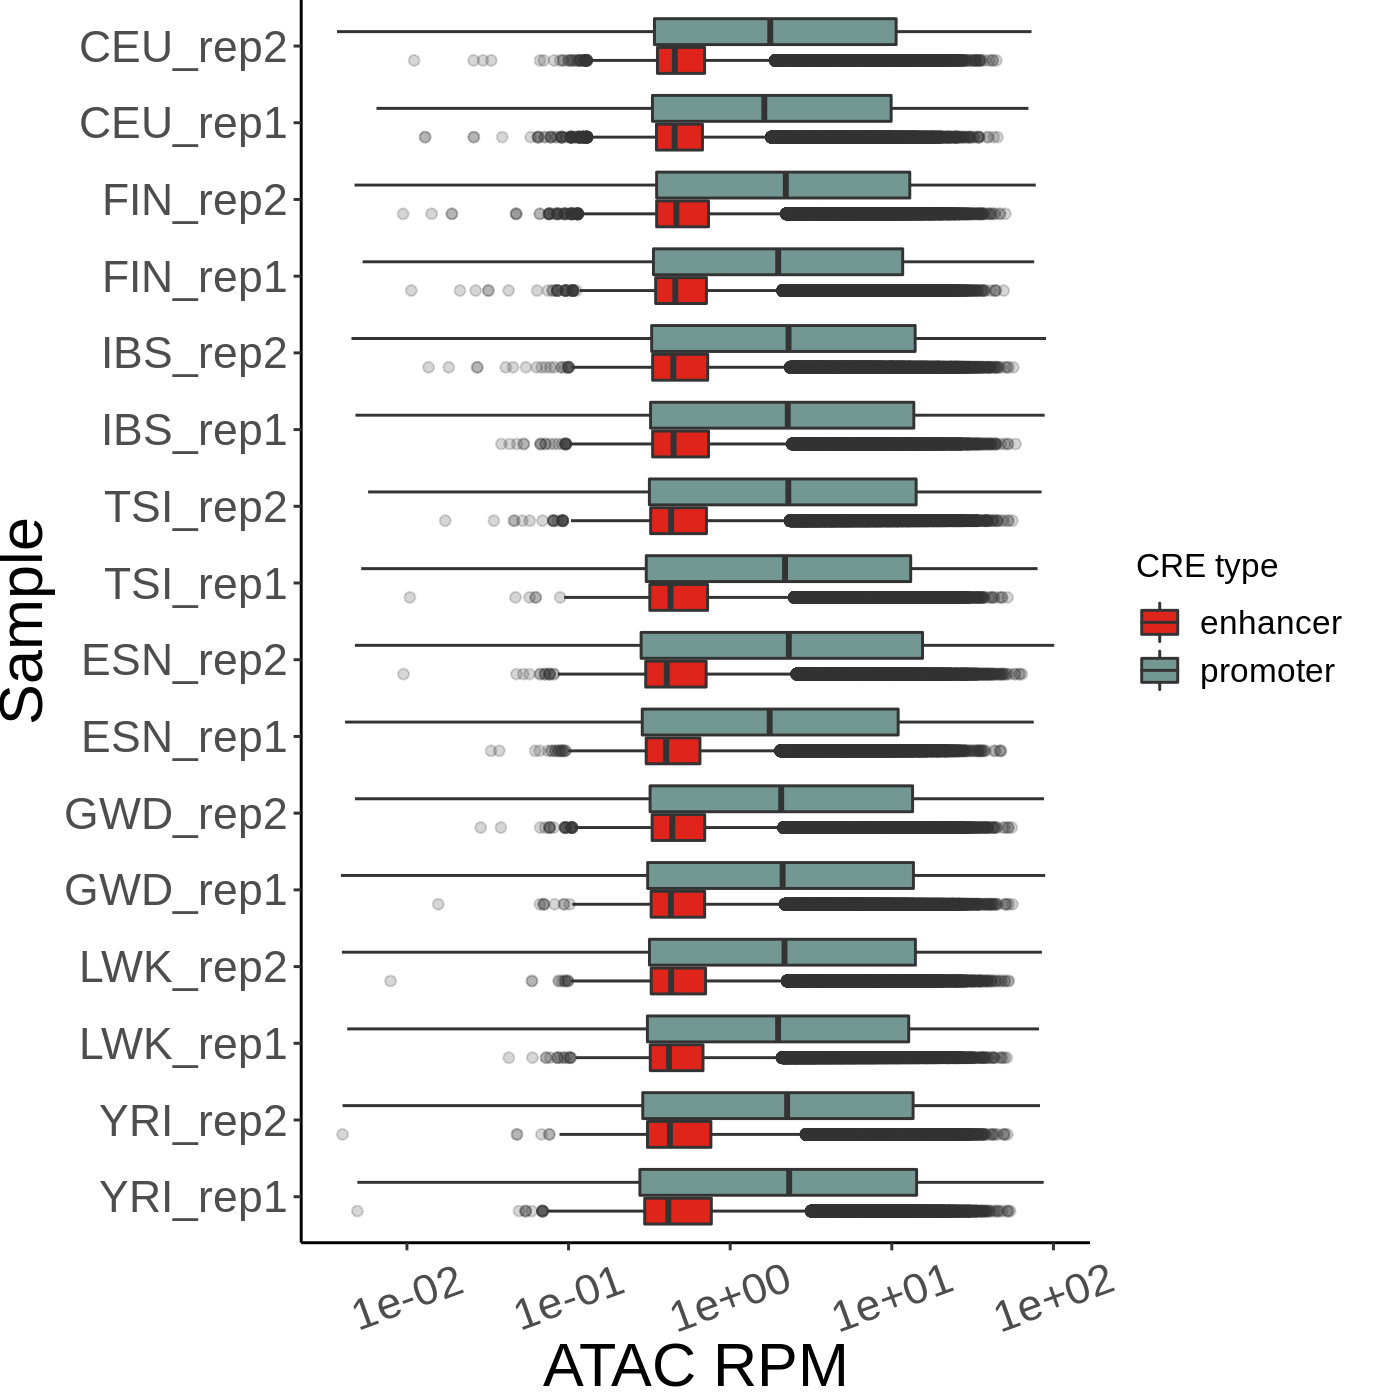

In [17]:
p4 <- groupedBoxplot(plotPrepFromMerge(adf %>% 
                                            dplyr::filter(if_all(starts_with('activity_base'), ~ . > 0)), 
                                       colprefix='activity_base') %>% 
                         mutate(class=if_else(class=='promoter','promoter','enhancer')),
                     'sample',
                     'activity_base',
                     groupvar='class',
                     grouplab='CRE type',
                     xlab='Sample',
                     ylab='ATAC RPM',
                     logscale=TRUE,
                     colorX=FALSE,
                     colorvals=cre_colors,
                     showleg=TRUE,
                     legendpos='right',
                     w=7,h=7)
p4

In [9]:
head(adf)

,chr,start,end,name,activity_base.CEU_rep1,hic_enh_total.CEU_rep1,activity_base.CEU_rep2,hic_enh_total.CEU_rep2,activity_base.ESN_rep1,hic_enh_total.ESN_rep1,activity_base.ESN_rep2,hic_enh_total.ESN_rep2,activity_base.FIN_rep1,hic_enh_total.FIN_rep1,activity_base.FIN_rep2,hic_enh_total.FIN_rep2,activity_base.GWD_rep1,hic_enh_total.GWD_rep1,activity_base.GWD_rep2,hic_enh_total.GWD_rep2,activity_base.IBS_rep1,hic_enh_total.IBS_rep1,activity_base.IBS_rep2,hic_enh_total.IBS_rep2,activity_base.LWK_rep1,hic_enh_total.LWK_rep1,activity_base.LWK_rep2,hic_enh_total.LWK_rep2,activity_base.TSI_rep1,hic_enh_total.TSI_rep1,activity_base.TSI_rep2,hic_enh_total.TSI_rep2,activity_base.YRI_rep1,hic_enh_total.YRI_rep1,activity_base.YRI_rep2,hic_enh_total.YRI_rep2
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,100009861,100010371,intergenic|chr1:100009861-100010371,0.440604,167,0.362103,77,0.530029,25,0.581345,28,0.303273,14,0.218037,52,0.453200,0,0.471945,0,0.297683,68,0.254138,114,0.358746,109,0.415544,0,0.427647,0,0.517616,40,0.384692,319,0.439766,283
2,chr1,100022623,100023123,intergenic|chr1:100022623-100023123,0.473001,197,0.332543,81,0.488620,25,0.281142,0,0.271349,0,0.208557,40,0.203159,0,0.405205,29,0.268875,0,0.190604,83,0.405725,97,0.332435,86,0.406786,42,0.425595,0,0.483330,300,0.447762,306
3,chr1,100023419,100023919,intergenic|chr1:100023419-100023919,0.259179,197,0.273425,81,0.509324,25,0.290673,0,0.218144,0,0.151678,40,0.261762,0,0.143014,29,0.244868,0,0.127069,83,0.525307,97,0.368053,86,0.307697,42,0.402590,0,0.305780,300,0.375800,306
4,chr1,10003167,10003735,promoter|chr1:10003167-10003735,13.179231,1090,15.363502,310,12.629590,269,18.579223,346,17.041812,253,18.087564,688,16.201917,408,16.675375,437,18.576350,594,19.800087,1134,14.281515,718,16.154770,545,17.940294,415,20.509084,506,17.044796,1913,16.431260,2083
5,chr1,100064485,100065150,intergenic|chr1:100064485-100065150,0.362850,147,0.343628,0,0.306423,0,0.343089,0,0.377761,0,0.360234,27,0.328180,0,0.286027,0,0.235265,47,0.254138,85,0.251976,61,0.320563,61,0.370279,25,0.368082,0,0.350168,232,0.287847,224
6,chr1,10007099,10007663,genic|chr1:10007099-10007663,0.375809,427,0.384272,126,0.314705,77,0.362150,88,0.345838,77,0.308095,204,0.367249,105,0.409972,124,0.427318,197,0.290444,345,0.439891,237,0.288902,205,0.333773,115,0.270310,142,0.226869,692,0.255864,679


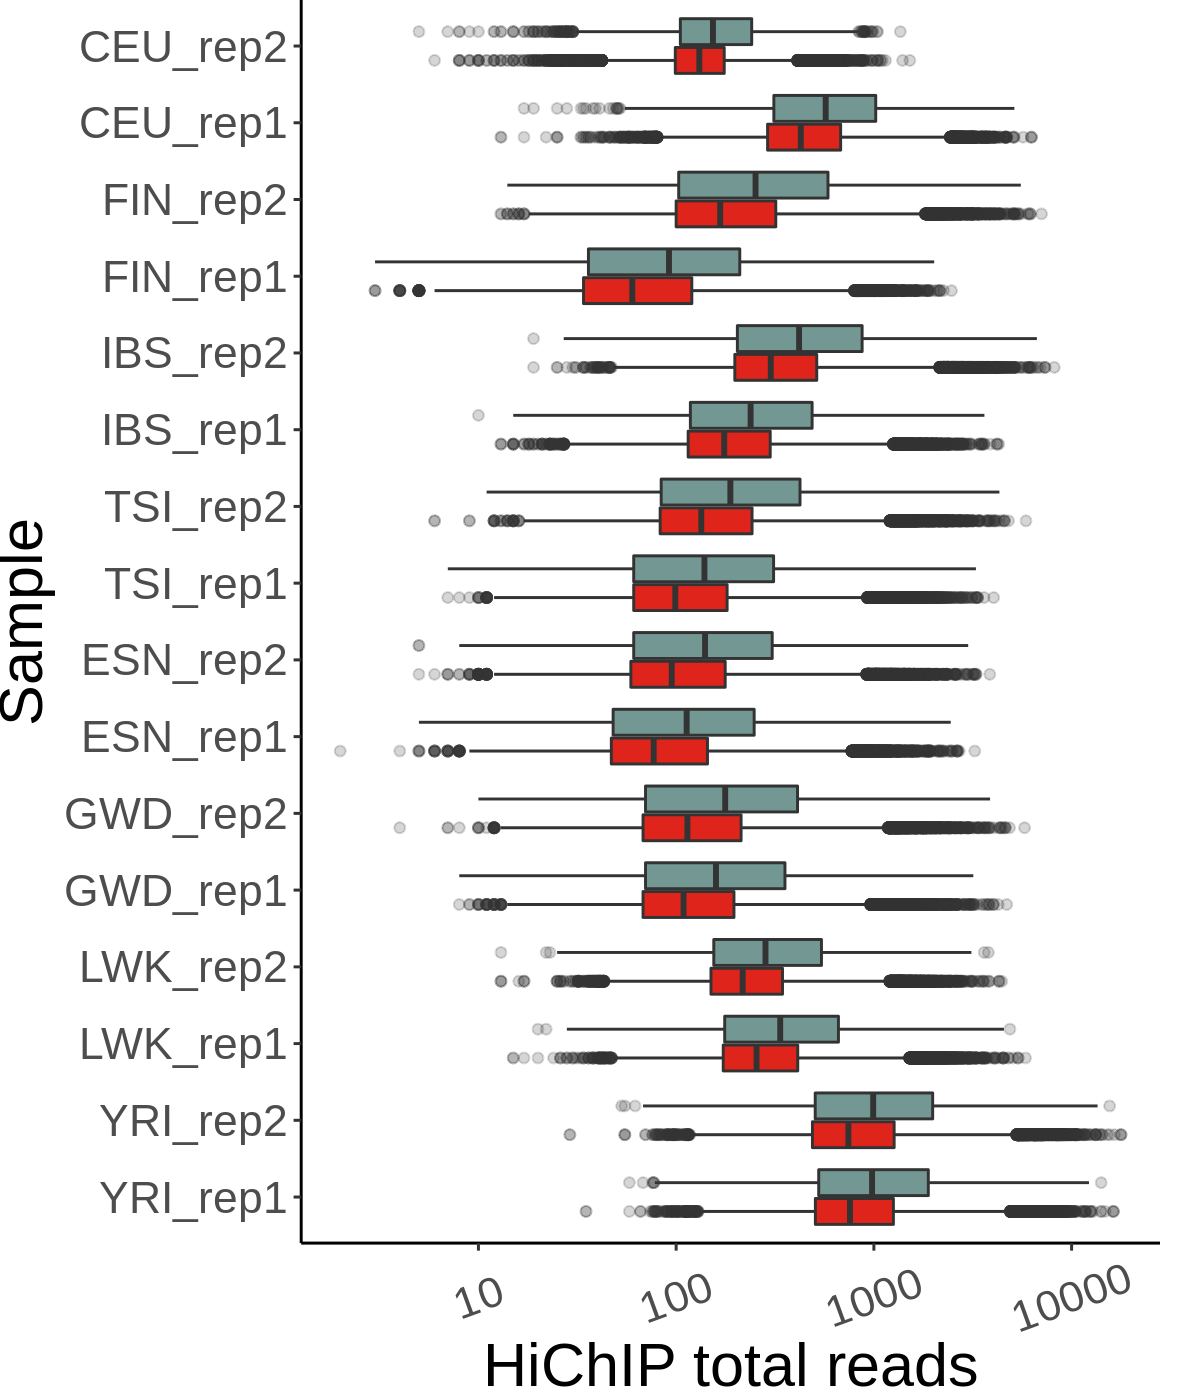

In [15]:
p5 <- groupedBoxplot(plotPrepFromMerge(adf %>% 
                                            dplyr::filter(if_all(starts_with('hic_enh_total'), ~ . > 0)), 
                                       colprefix='hic_enh_total') %>% 
                         mutate(class=if_else(class=='promoter','promoter','enhancer')),
                     'sample',
                     'hic_enh_total',
                     groupvar='class',
                     grouplab='CRE type',
                     xlab='Sample',
                     ylab='HiChIP total reads',
                     logscale=TRUE,
                     colorX=FALSE,
                     colorvals=cre_colors,
                     showleg=FALSE,
                     legendpos='right',
                     w=6,h=7)
p5

In [18]:
outdir <- '/home/kpettie/nf_selection/abc/from_sherlock/abc_1000G/manuscript/figs/noCEU'

ggsave(
    file.path(
        outdir, 
        'FigS2a_coverage.png'
    ),
    plot=p4,
    width=7, 
    height=7
)

In [16]:
ggsave(
    file.path(
        outdir, 
        'FigS2b_coverage.png'
    ),
    plot=p5,
    width=6, 
    height=7
)